In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import NonlinearConstraint

In [2]:
import nlopt

In [3]:
from truss import Node, Bar, Truss

In [4]:
n00 = Node(0.03,0.12160,freex=False, freey=False)
n01 = Node((30+140+320)*1e-3,0.12160, freex=False, freey=False)
n11 = Node(170e-3,0.12160-0.03)
n11.apply_load(0, -7.5e3)

In [5]:
xpos = np.linspace(0, 0.520, num=9)
ypos = np.linspace(0, 0.20320, num=9)

In [6]:
xpos

array([0.   , 0.065, 0.13 , 0.195, 0.26 , 0.325, 0.39 , 0.455, 0.52 ])

In [7]:
nodes = [n00, n01, n11]
for x in xpos:
    for y in ypos:
        #nodes.append(Node(x+np.random.uniform(-0.05, 0.05), y+np.random.uniform(-0.05, 0.05)))
        nodes.append(Node(x, y))

In [8]:
gridTruss = Truss.from_delaunay(nodes)
gridTruss.set_all_widths(0.01)

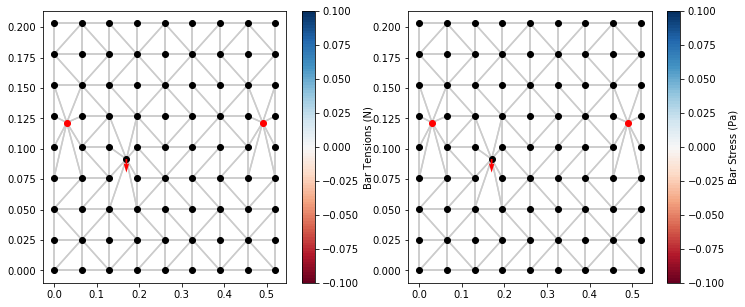

In [9]:
gridTruss.plot()

In [10]:
#gridTruss.set_widths(1e-2*np.random.rand(len(gridTruss.bars)))

In [11]:
gridTruss.details()

/Users/Devansh/Documents/GitHub/AVD_Initial_Sizing/Detailed_Design/truss.py:466: RuntimeWarning: divide by zero encountered in double_scalars
  bar_deets = [[i, b.node0, b.node1, b.E/10**9, b.yield_strength/10**6, b.w*1000, b.t*1000, b.area()*10**6, b.I()*10**12, b.length(), b.mass(), b.buckling_load(), b.tension(), b.extension()*1000, b.stress()/10**6, b.strain(), b.qBuckle(), b.qYield(), -min(b.buckling_load()/b.tension(), 0), b.yield_strength/b.stress()] for i, b in enumerate(self.bars)]


(    ID  x (m)   y (m)  Free x?  Free y?  Force x (N)  Force y (N)  \
 0    0  0.390  0.1016     True     True            0          0.0   
 1    1  0.000  0.1016     True     True            0          0.0   
 2    2  0.065  0.1016     True     True            0          0.0   
 3    3  0.455  0.1016     True     True            0          0.0   
 4    4  0.520  0.1016     True     True            0          0.0   
 5    5  0.195  0.1016     True     True            0          0.0   
 6    6  0.130  0.1016     True     True            0          0.0   
 7    7  0.000  0.1778     True     True            0          0.0   
 8    8  0.065  0.1778     True     True            0          0.0   
 9    9  0.130  0.1778     True     True            0          0.0   
 10  10  0.195  0.1778     True     True            0          0.0   
 11  11  0.390  0.1778     True     True            0          0.0   
 12  12  0.455  0.2032     True     True            0          0.0   
 13  13  0.520  0.20

In [12]:
gridTruss.solve()

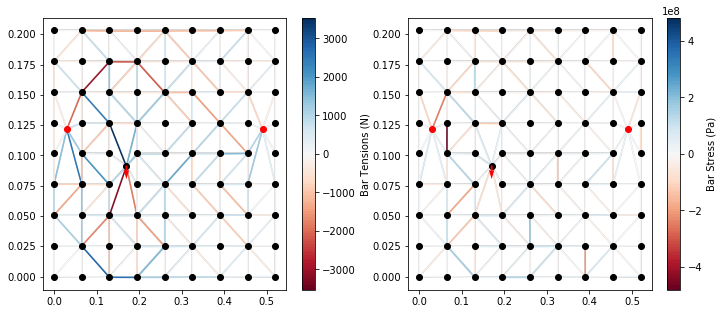

In [13]:
gridTruss.plot()

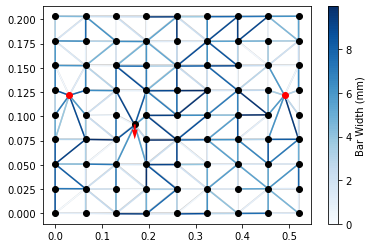

In [14]:
gridTruss.plot_widths()

In [15]:
gridTruss.mass()

0.8931284312103305

In [16]:
gridTruss.details()

(    ID  x (m)   y (m)  Free x?  Free y?  Force x (N)  Force y (N)  \
 0    0  0.390  0.1016     True     True            0          0.0   
 1    1  0.000  0.1016     True     True            0          0.0   
 2    2  0.065  0.1016     True     True            0          0.0   
 3    3  0.455  0.1016     True     True            0          0.0   
 4    4  0.520  0.1016     True     True            0          0.0   
 5    5  0.195  0.1016     True     True            0          0.0   
 6    6  0.130  0.1016     True     True            0          0.0   
 7    7  0.000  0.1778     True     True            0          0.0   
 8    8  0.065  0.1778     True     True            0          0.0   
 9    9  0.130  0.1778     True     True            0          0.0   
 10  10  0.195  0.1778     True     True            0          0.0   
 11  11  0.390  0.1778     True     True            0          0.0   
 12  12  0.455  0.2032     True     True            0          0.0   
 13  13  0.520  0.20

In [17]:
algo = nlopt.LD_MMA
n = len(gridTruss.bars)
opt = nlopt.opt(algo, n)

In [18]:
opt

<nlopt.opt; proxy of <Swig Object of type 'nlopt::opt *' at 0x11cf5e8d0> >

In [19]:
def mass_f(x, grad):
    
    if grad.size > 0:
        
        grad[:] = [bar.t*bar.length()*bar.density for bar in gridTruss.bars]
    
    gridTruss.set_widths(x)
    
    return gridTruss.mass()

opt.set_min_objective(mass_f)

In [20]:
opt.remove_equality_constraints()
opt.remove_inequality_constraints()

opt.set_lower_bounds(0.1e-3)
opt.set_upper_bounds(100e-3)

In [21]:
def stiff_f(x, grad):
    if grad.size > 0:
        
        grad[:] = [bar.t * bar.stress()**2 * bar.length() / bar.E for bar in gridTruss.bars]
    
    gridTruss.set_widths(x)
    
    gridTruss.solve()
    
    return np.dot(gridTruss.F, gridTruss.u) - 7.5e3*5e-3


opt.add_inequality_constraint(stiff_f)

In [22]:
def buckling_fc(x, grad):
        
    gridTruss.set_widths(x)
    gridTruss.solve()
    
    s = 0.0
    s += sum(- b.tension() for b in gridTruss.bars if b.tension() + b.buckling_load() < 0)
    
    return s

#opt.add_inequality_constraint(buckling_fc)

In [23]:
def c(result, x, grad):
    
    gridTruss.set_widths(x)
    
    gridTruss.solve()
    
    result[:] = [- b.tension() - b.buckling_load() for b in gridTruss.bars]
    
    
#opt.add_inequality_mconstraint(c, np.zeros(n))
#opt.add_equality_constraint(h, tol=0)

In [24]:
#opt.set_xtol_rel(0.01e-3)
opt.set_maxtime(60*3)

In [25]:
x0 = np.array([20e-3 for b in gridTruss.bars])
xopt = opt.optimize(x0)

In [26]:
mass_f(x0, np.ones(0)),stiff_f(x0, np.ones(0)) # when tmax = 60

(3.7672455541957475, -36.57294212179918)

In [27]:
mass_f(xopt, np.ones(0)),stiff_f(xopt, np.ones(0)) # when tmax = 60

(0.8905508155803292, -1.1866063687193673e-12)

In [28]:
result = opt.last_optimize_result()
result

6

In [29]:
n11.dy*10**3

-4.999999999999842

In [30]:
x0

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.

In [31]:
xopt

array([0.00555953, 0.00786956, 0.00346998, 0.0034766 , 0.00344517,
       0.00176827, 0.00160156, 0.00347118, 0.00161896, 0.00185404,
       0.0034665 , 0.00344841, 0.00345966, 0.00329094, 0.00346718,
       0.00347294, 0.00347097, 0.00347294, 0.00341677, 0.00343612,
       0.00346075, 0.00341808, 0.00339544, 0.01224238, 0.01224129,
       0.01224238, 0.01224235, 0.01224238, 0.00346524, 0.00208115,
       0.00347207, 0.0001    , 0.00974297, 0.00562788, 0.00253405,
       0.00141254, 0.01224235, 0.00347534, 0.00206361, 0.00252697,
       0.01224054, 0.01224167, 0.00346406, 0.00186787, 0.01224172,
       0.01224228, 0.00230931, 0.0122423 , 0.01224238, 0.00181064,
       0.00150245, 0.01224054, 0.00164166, 0.01224094, 0.01224119,
       0.0022529 , 0.0109441 , 0.0109441 , 0.011224  , 0.00182352,
       0.01224087, 0.00258026, 0.00689948, 0.01224227, 0.01223862,
       0.01224235, 0.01224237, 0.01224219, 0.00173733, 0.01224234,
       0.01224217, 0.01223664, 0.01223672, 0.01223845, 0.01224

In [32]:
xopt

array([0.00555953, 0.00786956, 0.00346998, 0.0034766 , 0.00344517,
       0.00176827, 0.00160156, 0.00347118, 0.00161896, 0.00185404,
       0.0034665 , 0.00344841, 0.00345966, 0.00329094, 0.00346718,
       0.00347294, 0.00347097, 0.00347294, 0.00341677, 0.00343612,
       0.00346075, 0.00341808, 0.00339544, 0.01224238, 0.01224129,
       0.01224238, 0.01224235, 0.01224238, 0.00346524, 0.00208115,
       0.00347207, 0.0001    , 0.00974297, 0.00562788, 0.00253405,
       0.00141254, 0.01224235, 0.00347534, 0.00206361, 0.00252697,
       0.01224054, 0.01224167, 0.00346406, 0.00186787, 0.01224172,
       0.01224228, 0.00230931, 0.0122423 , 0.01224238, 0.00181064,
       0.00150245, 0.01224054, 0.00164166, 0.01224094, 0.01224119,
       0.0022529 , 0.0109441 , 0.0109441 , 0.011224  , 0.00182352,
       0.01224087, 0.00258026, 0.00689948, 0.01224227, 0.01223862,
       0.01224235, 0.01224237, 0.01224219, 0.00173733, 0.01224234,
       0.01224217, 0.01223664, 0.01223672, 0.01223845, 0.01224

In [33]:
min(xopt)*1e3, max(xopt)*1e3

(0.1, 12.242380642812606)

In [34]:
gridTruss.set_widths(xopt)
gridTruss.solve()
gridTruss.mass()

0.8905508155803292

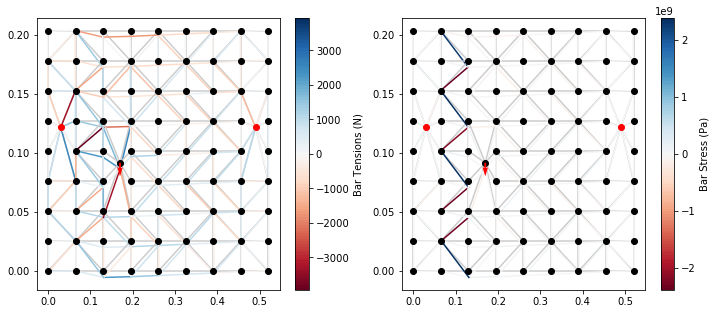

In [35]:
gridTruss.plot()

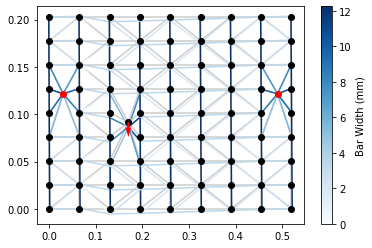

In [36]:
gridTruss.plot_widths()

In [37]:
df_n, df_b = gridTruss.details()

In [38]:
df_n

,ID,x (m),y (m),Free x?,Free y?,Force x (N),Force y (N),Delta x (mm),Delta y (mm)
0,0,0.390,0.1016,True,True,0,0.0,0.248927,-1.570769
1,1,0.000,0.1016,True,True,0,0.0,0.221922,-0.332884
2,2,0.065,0.1016,True,True,0,0.0,0.148457,0.260652
3,3,0.455,0.1016,True,True,0,0.0,0.275531,-0.501654
4,4,0.520,0.1016,True,True,0,0.0,0.262236,0.393353
5,5,0.195,0.1016,True,True,0,0.0,0.217826,-4.676001
6,6,0.130,0.1016,True,True,0,0.0,0.242913,-5.300512
7,7,0.000,0.1778,True,True,0,0.0,-0.597392,-0.332900
8,8,0.065,0.1778,True,True,0,0.0,-0.620546,0.266429
9,9,0.130,0.1778,True,True,0,0.0,-0.643701,-5.288658


In [39]:
df_b

,ID,Node 0,Node 1,E (GPa),Yield (MPa),w (mm),t (mm),A (mm2),I (mm4),L (m),m (kg),Buckling Load (N),T (N),ext (mm),Stress (MPa),Strain,Will buckle?,Will yield?,Buckle Margin,Yield Margin
0,0,"N(0.49, 0.12)","N(0.52, 0.08)",71.0,300.0,5.559529,6.35,35.303007,90.929831,0.054417,0.005187,21518.034727,-4.394453e+01,-9.540381e-04,-1.244781e+00,-1.753213e-05,False,False,4.896636e+02,-2.410062e+02
1,1,"N(0.17, 0.09)","N(0.20, 0.13)",71.0,300.0,7.869557,6.35,49.971689,167.915286,0.043338,0.005847,62649.230452,2.562724e+03,3.130298e-02,5.128352e+01,7.223030e-04,False,False,0.000000e+00,5.849833e+00
2,2,"N(0.13, 0.03)","N(0.20, 0.03)",71.0,300.0,3.469980,6.35,22.034372,22.109216,0.065000,0.003867,3666.947732,5.180846e+02,2.152559e-02,2.351256e+01,3.311629e-04,False,False,0.000000e+00,1.275914e+01
3,3,"N(0.00, 0.03)","N(0.07, 0.03)",71.0,300.0,3.476601,6.35,22.076415,22.236014,0.065000,0.003874,3687.978027,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,False,False,0.000000e+00,inf
4,4,"N(0.26, 0.03)","N(0.33, 0.03)",71.0,300.0,3.445170,6.35,21.876830,21.638366,0.065000,0.003839,3588.854356,1.062320e+03,4.445554e-02,4.855913e+01,6.839314e-04,False,False,0.000000e+00,6.178035e+00
5,5,"N(0.26, 0.08)","N(0.33, 0.05)",71.0,300.0,1.768273,6.35,11.228533,2.925771,0.069787,0.002116,420.973934,-8.084033e+02,-7.076497e-02,-7.199545e+01,-1.014020e-03,True,False,5.207474e-01,-4.166930e+00
6,6,"N(0.33, 0.08)","N(0.39, 0.05)",71.0,300.0,1.601557,6.35,10.169889,2.173802,0.069787,0.001916,312.776960,-9.856888e+02,-9.526577e-02,-9.692228e+01,-1.365103e-03,True,False,3.173182e-01,-3.095264e+00
7,7,"N(0.39, 0.03)","N(0.46, 0.03)",71.0,300.0,3.471181,6.35,22.041997,22.132176,0.065000,0.003868,3670.755749,4.429329e+02,1.839679e-02,2.009496e+01,2.830275e-04,False,False,0.000000e+00,1.492912e+01
8,8,"N(0.39, 0.08)","N(0.46, 0.05)",71.0,300.0,1.618958,6.35,10.280386,2.245430,0.069787,0.001937,323.083235,-8.594091e+02,-8.216821e-02,-8.359697e+01,-1.177422e-03,True,False,3.759365e-01,-3.588647e+00
9,9,"N(0.39, 0.18)","N(0.46, 0.15)",71.0,300.0,1.854036,6.35,11.773130,3.372463,0.069787,0.002218,485.246085,-9.119349e+02,-7.613514e-02,-7.745900e+01,-1.090972e-03,True,False,5.321060e-01,-3.873017e+00


In [40]:
df_b[['w (mm)', 'Buckling Load (N)', 'T (N)','Will buckle?']]

,w (mm),Buckling Load (N),T (N),Will buckle?
0,5.559529,21518.034727,-4.394453e+01,False
1,7.869557,62649.230452,2.562724e+03,False
2,3.469980,3666.947732,5.180846e+02,False
3,3.476601,3687.978027,0.000000e+00,False
4,3.445170,3588.854356,1.062320e+03,False
5,1.768273,420.973934,-8.084033e+02,True
6,1.601557,312.776960,-9.856888e+02,True
7,3.471181,3670.755749,4.429329e+02,False
8,1.618958,323.083235,-8.594091e+02,True
9,1.854036,485.246085,-9.119349e+02,True


In [41]:
max(b.w for b in gridTruss.bars)

0.012242380642812606